# Importación de librerías

In [1]:
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
import os
from io import BytesIO
import re
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from PIL import Image
#import PIL
from PIL import UnidentifiedImageError
from PIL import ImageFile
from keras.utils import load_img
from keras_preprocessing.image import img_to_array
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.python.keras.models import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

# Carga de datos y breve exploración

Se creará un bucle que recorra cada uno de los elementos.

Se usará la funcion load_img() que nos devolverá una imagen PIL



In [2]:

imagenes = []
clase = []

for root, dirs, files in os.walk("COVID-19_Radiography_Dataset"):
    for filename in files:
        img_path = os.path.join(root, filename)
        img = load_img(img_path)
        imagenes.append(img)
    for filename in files:
        clase.append(filename)

In [3]:
print('El dataset consta de', len(imagenes),'radiografias')

El dataset consta de 21165 radiografias


Se mostrará una imagen de cada diagnostico:

Viral Pneumonia


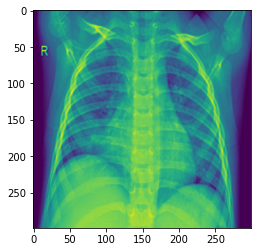

In [4]:
path1 = "C:/Users/Usuario/Documents/MasterPython/TFM/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1003.png"
new_img1 = Image.open(path1)
img1 = np.array(new_img1)
img1 = np.expand_dims(img1, axis=0)
print("Viral Pneumonia")
plt.imshow(new_img1)

COVID Pneumonia


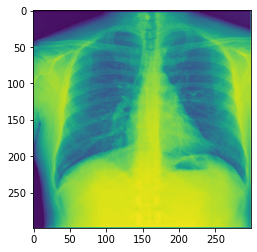

In [5]:
path2 = "C:/Users/Usuario/Documents/MasterPython/TFM/COVID-19_Radiography_Dataset/COVID/COVID-1003.png"
new_img2 = Image.open(path2)
img2 = np.array(new_img2)
img2 = np.expand_dims(img2, axis=0)
print("COVID Pneumonia")
plt.imshow(new_img2)

Normal


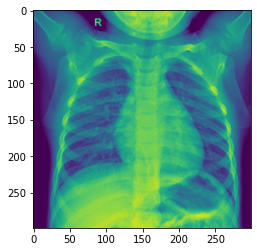

In [6]:
path3 = "C:/Users/Usuario/Documents/MasterPython/TFM/COVID-19_Radiography_Dataset/NORMAL/NORMAL-1013.png"
new_img3 = Image.open(path3)
img3 = np.array(new_img3)
img3 = np.expand_dims(img3, axis=0)
print("Normal")
plt.imshow(new_img3)

Opacidad pulmonar


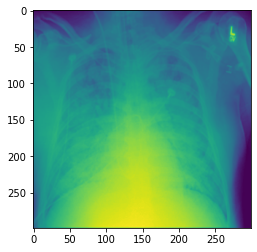

In [7]:
path4 = "C:/Users/Usuario/Documents/MasterPython/TFM/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1003.png"
new_img4 = Image.open(path4)
img4 = np.array(new_img4)
img4 = np.expand_dims(img4, axis=0)
print("Opacidad pulmonar")
plt.imshow(new_img4)

In [8]:
# Simplificaremos la variable diagnostico quedandonos solo con el nombre
diagnostico = []
for filenames in clase:
    x = filenames.split(sep ='-')
    x = x[0]
    diagnostico.append(x) 

# Las imagenes en formato PIL tienen una serie de atributos, con las que crearemos
# las variables Size y Modo
Size = []
for i in imagenes:
    x = i.size
    Size.append(x)

Modo = []
for i in imagenes:
    Modo.append(i.mode)

Se crea el dataset:

In [9]:
df = pd.DataFrame({
    "diagnostico" : diagnostico,
    "Size" : Size,
    "Modo" : Modo })

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   diagnostico  21165 non-null  object
 1   Size         21165 non-null  object
 2   Modo         21165 non-null  object
dtypes: object(3)
memory usage: 496.2+ KB


In [11]:
df.head()

,diagnostico,Size,Modo
0,COVID,"(299, 299)",RGB
1,COVID,"(299, 299)",RGB
2,COVID,"(299, 299)",RGB
3,COVID,"(299, 299)",RGB
4,COVID,"(299, 299)",RGB


Vemos cuantas imágenes hay de cada tipo y observamos que no hay valores perdidos:

In [12]:
df.groupby("diagnostico").size()

diagnostico
COVID               3616
Lung_Opacity        6012
Normal             10192
Viral Pneumonia     1345
dtype: int64

In [13]:
print("El dataset muestra: ", df.groupby("diagnostico").size()[1], "radiografias con opacidad pulmonar, ",
     df.groupby("diagnostico").size()[2], "radiografias normales, ",
     df.groupby("diagnostico").size()[3], "radiografias neumonia vírica y  ",
     df.groupby("diagnostico").size()[0], "radiografias con covid")

El dataset muestra:  6012 radiografias con opacidad pulmonar,  10192 radiografias normales,  1345 radiografias neumonia vírica y   3616 radiografias con covid


c:\users\usuario\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='diagnostico', ylabel='count'>

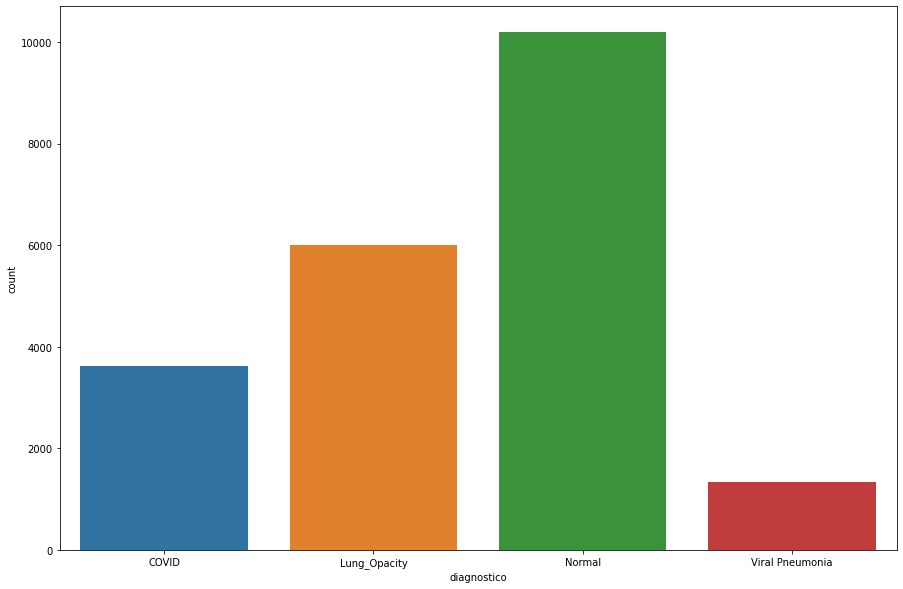

In [14]:
plt.figure(figsize=(15,10))
sns.countplot(df['diagnostico'])

# Reducción de datos y preprocesamiento

In [15]:
import random
from random import sample
import shutil

os.makedirs('/datos_reducidos', exist_ok = True)

In [17]:
# Se fija la semilla
random.seed('456789')

# Creamos las listas 
carpetas = []
clases = []

# lectura de las 4 carpetas
for carpeta in os.listdir("COVID-19_Radiography_Dataset"):
    # Se establece ruta
    carpeta_path = os.path.join("COVID-19_Radiography_Dataset",carpeta)
    # Union de las rutas en la lista carpetas
    carpetas.append(carpeta_path)
    
# Lectura de carpetas
for carpeta in carpetas:
    # asignacion de nombres (clase)
    nombre = carpeta.split(sep ='\\')[-1]
    clases.append(nombre)
    
    # Creamos dentro de los directorios Train y Valid las carpetas para cada clase
    os.makedirs('/datos_reducidos/' + nombre, exist_ok = True)
    
    
    archivos = []
    train_clase = []
    valid_clase = []
    
    # Lectura de archivos de cada carpeta 
    for archivo in os.listdir(carpeta):
        archivos.append(archivo)
        
    # Selección de 1300 imágenes de cada diagnostico
    seleccion = sample(archivos, 1300)
    
    # Copia de las imágenes en sus respectivas carpetas
    for imagen in seleccion:
        img_path = os.path.join(carpeta, imagen)
        shutil.copy(img_path, os.path.join('/datos_reducidos',nombre, imagen))

# Creacion de listas con las imagenes y sus etiquetas

In [18]:
IMAGENES = []
ETIQUETAS = []


# Leemos los archivos de Train
for root, dirs, files in os.walk('/datos_reducidos'):
    # Lectura
    for filename in files:
        # ruta
        img_path = os.path.join(root, filename)
        # Carga imagenes
        img = load_img(img_path)
        # cada imagen irá en su lista correspondiente 
        IMAGENES.append(img)
        
        # Obtenemos la etiqueta de cada imagen
        x = filename.split(sep ='-')
        x = x[0]
        # Añadimos la clase a la lista de labels
        ETIQUETAS.append(x)

In [19]:
print(len(IMAGENES))
print(len(ETIQUETAS))

5923
5923


# Prepocesamiento de imagenes

Se transformará cada imagen en una matriz de pixeles, se redimensionará y se normalizará. Después se ejecutará la función para todas las imágenes.

In [20]:
def preprocesamiento(img):
    
    if img.mode != 'RGB':
         img = img.convert('RGB') 
    img_array = img_to_array(img)
    
    
    if img.size != (150, 150):
        img_array = tf.image.resize(img_array, (150, 150))
    img_norm = img_array/255
    
    return img_norm

In [21]:
x = []
for imagen in IMAGENES:
    img_preprocesada = preprocesamiento(imagen)
    x.append(img_preprocesada)

# Codificación de la variable clase

Se creará un diccionario y se le asignará a cada nombre su valor numérico

In [22]:
dic = {'COVID':0, 'Lung_Opacity':1, 'Normal':2, 'Viral Pneumonia': 3}

In [23]:
y = [dic.get(n, n) for n in ETIQUETAS]

In [24]:
set(ETIQUETAS)

{'COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'}

In [44]:
set(y)

{0, 1, 2, 3}

Transformación de lista a vector

In [25]:
x = np.array(x)
y = np.array(y)

In [26]:
len(x)

5923

In [45]:
len(y)

5923

# Creación de train, test y validación

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

In [28]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2)

In [29]:
print('Imágenes entrenamiento:',x_train.shape, 'Etiquetas:',y_train.shape)
print('Imágenes test:', x_test.shape, 'Etiquetas:',y_test.shape)
print('Imágenes validación:', x_valid.shape, 'Etiquetas:',y_valid.shape)

Imágenes entrenamiento: (3790, 150, 150, 3) Etiquetas: (3790,)
Imágenes test: (1185, 150, 150, 3) Etiquetas: (1185,)
Imágenes validación: (948, 150, 150, 3) Etiquetas: (948,)


# One-hot-encoding

In [31]:
from keras.utils import to_categorical

# Hacemos one-hot encoding de las clases 

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
y_valid_one_hot = to_categorical(y_valid)

print('Original:', y_train[2241], ', Codificación:', y_train_one_hot[2241])

Original: 0 , Codificación: [1. 0. 0. 0.]


In [32]:
x_train[1].shape

(150, 150, 3)

# Red neuronal

Usaremos una red neuronal convolucional 2D con 4 capas de convolución, con kernel de tamaño 3x3, lo que significa que tendremos 9 perceptrones interconectados. Se alimentaran los primeros 32 elementos del vector de entrada. 
Con MaxPooling2D se comprimirá el espacio de datos sin afectar mucho su información. Esto ayuda a acelerar el procesamiento y entrenamiento. Se repetirá este proceso. 
La instrucción Flatten convierte los elementos de la matriz de imágenes de entrada en un array plano. 
Con Dropout se eliminaran un 50 % de las conexiones. 
Por último se añade una capa densa (todas las neuronas se interconectan con todas las neuronas de la siguiente capa) con el número de salidas, que serán el total de clases que haya. 

In [33]:
from tensorflow.keras import layers
# Parametros
num_classes = 4
input_shape = (150, 150, 3)

#Construimos el modelo:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

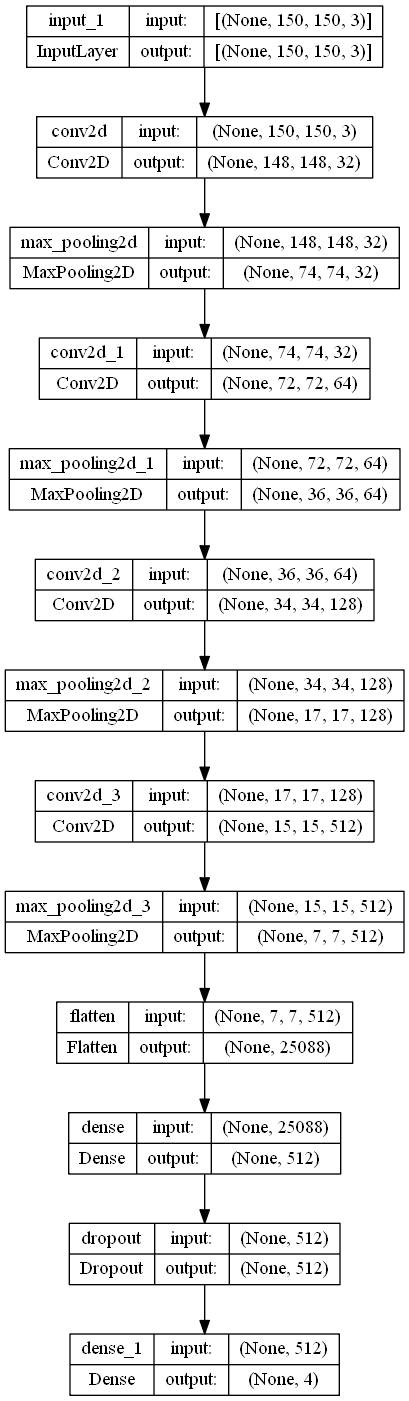

In [35]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

Entrenamiento del modelo:
Se utilizará la función fit() para el entrenamiento.

El bach_size (tamaño) se ha fijado en 128, es decir se usarán 128 imágenes para la actualización del gradiente. Se han establecido 20 épocas (epoch).

Para ver la precisión del modelo se usará la función evaluate().

In [36]:
batch_size = 128
#número de veces que iterará cada patron
epochs = 20
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
hist = model.fit(x_train, y_train_one_hot, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
27/27 [==============================] - 39s 1s/step - loss: 1.2363 - accuracy: 0.4380 - val_loss: 0.9392 - val_accuracy: 0.5805
Epoch 2/20
27/27 [==============================] - 39s 1s/step - loss: 0.8054 - accuracy: 0.6787 - val_loss: 0.7172 - val_accuracy: 0.7071
Epoch 3/20
27/27 [==============================] - 41s 2s/step - loss: 0.6986 - accuracy: 0.7162 - val_loss: 0.6897 - val_accuracy: 0.7335
Epoch 4/20
27/27 [==============================] - 40s 1s/step - loss: 0.5734 - accuracy: 0.7787 - val_loss: 0.5696 - val_accuracy: 0.7704
Epoch 5/20
27/27 [==============================] - 43s 2s/step - loss: 0.5172 - accuracy: 0.7995 - val_loss: 0.5045 - val_accuracy: 0.8047
Epoch 6/20
27/27 [==============================] - 40s 1s/step - loss: 0.4652 - accuracy: 0.8179 - val_loss: 0.4545 - val_accuracy: 0.8311
Epoch 7/20
27/27 [==============================] - 43s 2s/step - loss: 0.4272 - accuracy: 0.8352 - val_loss: 0.4904 - val_accuracy: 0.7995
Epoch 8/20
27/27 [==

In [37]:
model.save('modelo_original.h5')

In [39]:
scores = model.evaluate(x_test,y_test_one_hot, verbose = 0)

In [40]:
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

Test loss: 0.4998287856578827
Test accuracy: 0.853164553642273


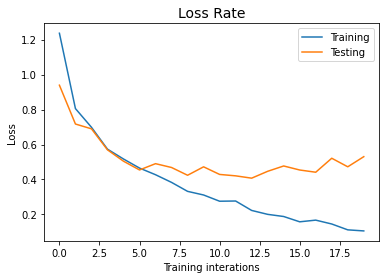

In [41]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Rate', size=14)
plt.ylabel('Loss')
plt.xlabel('Training interations')
plt.legend(['Training', 'Testing'], loc='upper right')
plt.show()


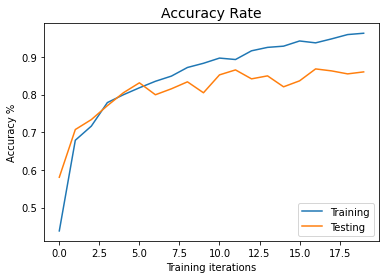

In [42]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy Rate', size=14)
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Training','Testing'], loc='lower right')
plt.show()
